In [1]:
import os
import warnings

import netCDF4 as nc
import numpy as np
import xarray as xr
import pandas as pd
import multiprocessing as mp
import matplotlib.pyplot as plt

from glob import glob

warnings.filterwarnings('ignore')
os.environ['OMP_NUM_THREADS'] = '1'

## Pull in GFSDS output

In [2]:
flist = sorted(glob('./gfsds/*.nc'))

gfsds = xr.open_mfdataset(flist)
gfsds['lead_time'] = ((gfsds.time - gfsds.time[0])/(3.6e12)).astype(int)

gfsds

<xarray.Dataset>
Dimensions:    (lat: 2392, lon: 3001, time: 29)
Coordinates:
  * lat        (lat) float32 29.99583 30.004164 30.012497 ... 49.91249 49.920822
  * lon        (lon) float32 -125.004166 -124.995834 ... -100.01251 -100.00417
  * time       (time) datetime64[ns] 2020-09-08 ... 2020-09-11T12:00:00
Data variables:
    dqpf       (time, lat, lon) float64 dask.array<shape=(29, 2392, 3001), chunksize=(1, 2392, 3001)>
    dqsf       (time, lat, lon) float64 dask.array<shape=(29, 2392, 3001), chunksize=(1, 2392, 3001)>
    prism      (time, lat, lon) float64 dask.array<shape=(29, 2392, 3001), chunksize=(1, 2392, 3001)>
    qpf        (time, lat, lon) float64 dask.array<shape=(29, 2392, 3001), chunksize=(1, 2392, 3001)>
    qsf        (time, lat, lon) float64 dask.array<shape=(29, 2392, 3001), chunksize=(1, 2392, 3001)>
    slr        (time, lat, lon) float64 dask.array<shape=(29, 2392, 3001), chunksize=(1, 2392, 3001)>
    wbzh       (time, lat, lon) float64 dask.array<shape=(29, 

## Ensure tally method functions properly

In [3]:
xqpf = gfsds['dqpf'].sum(dim='time')
xqpf_id = np.where(xqpf == xqpf.max())
xqpf_sample = gfsds.isel(lon=xqpf_id[1], lat=xqpf_id[0]).load()
xqpf_sample = xqpf_sample.isel(lat=0, lon=0)

In [4]:
apcp_24_test = []
for lead in np.arange(24, 84+1, 12):
    tidx = np.where(gfsds['lead_time'] == lead)[0][0]
    apcp_24 = xqpf_sample.isel(time=slice(tidx-7, tidx+1))['dqpf'].sum(dim='time')
    apcp_24_test.append([lead, apcp_24.values])
apcp_24_test = np.array(apcp_24_test)

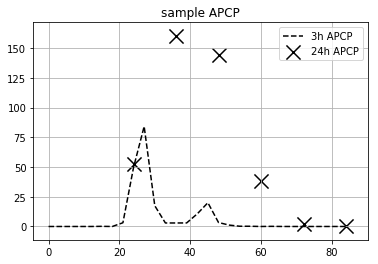

In [5]:
fig, ax = plt.subplots(1, facecolor='w')

ax.plot(xqpf_sample['lead_time'], xqpf_sample['dqpf'], 
        color='k', linestyle='--', label='3h APCP')
ax.scatter(apcp_24_test[:, 0], apcp_24_test[:, 1], 
           marker='x', color='k', s=200, linewidth=1.5, label='24h APCP')

ax.set_title('sample APCP')
ax.legend()
ax.grid()
plt.show()

## 2d Lat Lon Needed, use Meshgrid

In [6]:
lat, lon = gfsds['lat'], gfsds['lon']
lon2d, lat2d = np.meshgrid(lon, lat)

## Create NetCDF Files for WPC MODE 
#### Tally APCP, ASNOW, mean SLR for 24 hours/every 12 hours

In [9]:
for lead in np.arange(24, 84+1, 12):
    
    tidx = np.where(gfsds['lead_time'] == lead)[0][0]
    tslice = slice(tidx-7, tidx+1)
        
    itime = pd.to_datetime(gfsds.time.values[0])
    vtime = pd.to_datetime(gfsds.isel(time=tslice).time.values[-1])

    apcp_24 = gfsds.isel(time=tslice)['dqpf'].sum(dim='time')
    asnow_24 = gfsds.isel(time=tslice)['dqsf'].sum(dim='time')
    
    slr_24 = xr.where(asnow_24 > 0, gfsds.isel(time=slice(tidx-7, tidx+1))['slr'], np.nan)
    slr_24 = slr_24.mean(dim='time', skipna=True)
    slr_24 = xr.where(~np.isnan(slr_24), slr_24, 0.)
    
    ncfilename = './mode/uutah_downscaled_gfs.%s_f%03d_v%s.nc'%(
        itime.strftime('%Y%m%d_%H%M%S'), lead, vtime.strftime('%Y%m%d_%H%M%S'))
    
    try:
        os.remove(ncfilename)
    except:
        pass
    
    ncfile = nc.Dataset(ncfilename, 'w', format='NETCDF4')

    # Global Attributes
    ncfile.init_time = itime.strftime('%Y%m%d_%H%M%S')
    ncfile.init_time_ut = itime.timestamp()
    ncfile.valid_time = vtime.strftime('%Y%m%d_%H%M%S')
    ncfile.valid_time_ut = vtime.timestamp()

    # Lat Lon dimensions and data
    ncfile.createDimension('lon', len(lon))
    ncfile.createDimension('lat', len(lat))

    lon_nc = ncfile.createVariable('lon', 'f4', ('lat', 'lon'))
    lon_nc.long_name = 'longitude'
    lon_nc.units = 'degrees_east'
    lon_nc.standard_name = 'longitude'
    lon_nc._CoordinateAxisType = 'Lon'

    lat_nc = ncfile.createVariable('lat', 'f4', ('lat', 'lon'))
    lat_nc.long_name = 'latitude'
    lat_nc.units = 'degrees_north'
    lat_nc.standard_name = 'latitude'
    lat_nc._CoordinateAxisType = 'Lat'

    lon_nc[:] = lon2d
    lat_nc[:] = lat2d

    # Write variable data
    apcp_24_nc = ncfile.createVariable('APCP_R1', 'f4', ('lat', 'lon'), fill_value=-9999.0)
    apcp_24_nc.long_name = 'Total Precipitation'
    apcp_24_nc.level = 'R1'
    apcp_24_nc.units = 'inches'

    asnow_24_nc = ncfile.createVariable('ASNOW_R1', 'f4', ('lat', 'lon'), fill_value=-9999.0)
    asnow_24_nc.long_name = 'Total Snow'
    asnow_24_nc.level = 'R1'
    asnow_24_nc.units = 'inches'

    slr_24_nc = ncfile.createVariable('SLR_R1', 'f4', ('lat', 'lon'), fill_value=-9999.0)
    slr_24_nc.long_name = 'Snow Liquid Ratio'
    slr_24_nc.level = 'R1'
    slr_24_nc.units = 'ratio'

    mm_in = 1/25.4
    apcp_24_nc[:] = apcp_24.values * mm_in
    asnow_24_nc[:] = asnow_24.values * mm_in
    slr_24_nc[:] = slr_24.values

    print('lead %d ncfile %s written'%(lead, ncfilename))
    ncfile.close()

lead 24 ncfile ./mode/uutah_downscaled_gfs.20200908_000000_f024_v20200909_000000.nc written
lead 36 ncfile ./mode/uutah_downscaled_gfs.20200908_000000_f036_v20200909_120000.nc written
lead 48 ncfile ./mode/uutah_downscaled_gfs.20200908_000000_f048_v20200910_000000.nc written
lead 60 ncfile ./mode/uutah_downscaled_gfs.20200908_000000_f060_v20200910_120000.nc written
lead 72 ncfile ./mode/uutah_downscaled_gfs.20200908_000000_f072_v20200911_000000.nc written
lead 84 ncfile ./mode/uutah_downscaled_gfs.20200908_000000_f084_v20200911_120000.nc written
